100.0%
100.0%
100.0%
100.0%


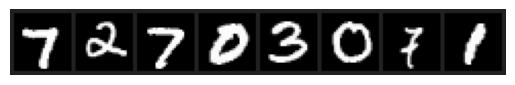

Labels: 7 2 7 0 3 0 7 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms


#Defining transform --- tensor and normalization -----

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#Load MNIST dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)





#Visualize these
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()



#training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display images
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join(str(label.item()) for label in labels[:8]))


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# CNN architecture
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()

        # Convolution Layer 1: 1 input (grayscale), 16 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        # Convolution Layer 2: 16 input -> 32 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # MaxPooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 28x28 → pooled twice → 7x7
        self.fc2 = nn.Linear(128, 10)          # 10 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 32 * 7 * 7)            
        x = F.relu(self.fc1(x))               
        x = self.fc2(x)                       
        return x


In [4]:
import torch.optim as optim

# gpu or cpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Initialize model and move it to device
model = DigitCNN().to(device)

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training loop
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()             # Reset gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                   # Backpropagation
        optimizer.step()                  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Using device: cpu
Epoch [1/5], Loss: 0.1604
Epoch [2/5], Loss: 0.0499
Epoch [3/5], Loss: 0.0359
Epoch [4/5], Loss: 0.0256
Epoch [5/5], Loss: 0.0210


In [5]:
# Evaluation
model.eval()  
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 99.09%


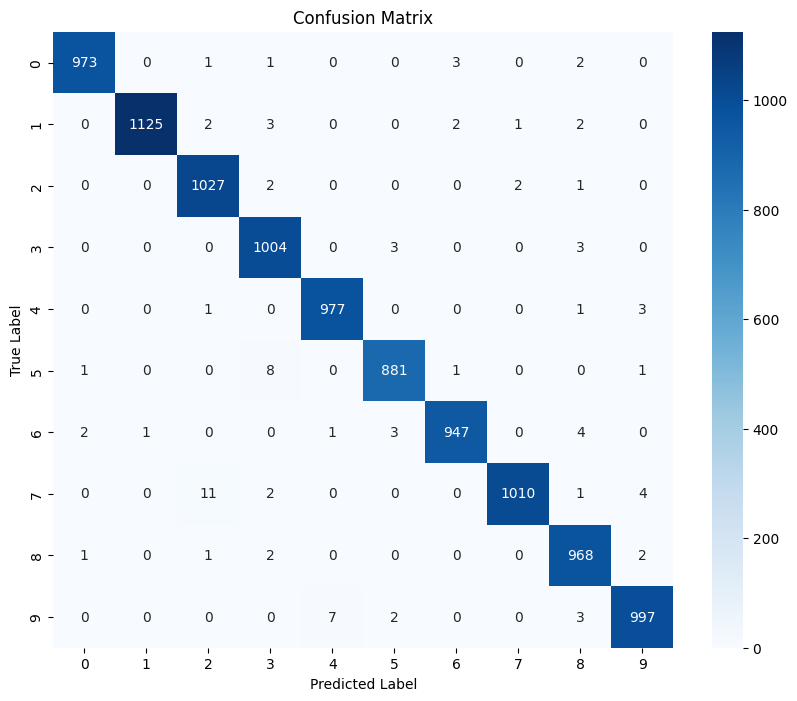

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions for the full test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
